> **_NOTE:_** code in cell below is from lecture.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def ray(n, s, theta):
    """
    Trace ray:
        x(t) =  t*sin(theta) + s*cos(theta)
        y(t) = -t*cos(theta) + s*sin(theta)
    through volume [-1,1]^2, discretised with n x n pixels.
    
    Returns linear indices of intersected pixels and corresponding intersection lengths
    """
    
    # define boundaries of pixels
    h = 2/n
    x = -1 + np.linspace(0,n,n+1)*h
    y = -1 + np.linspace(0,n,n+1)*h
    
    # compute all intersections with horizontal and vertical grid lines
    # in terms of path length parameter t
    t = []
    if np.abs(np.sin(theta)) > 0:
        tx = (x - s*np.cos(theta))/np.sin(theta)
        t = np.concatenate((t,tx))
    if np.abs(np.cos(theta)) > 0 :
        ty = -(y - s*np.sin(theta))/np.cos(theta)
        t = np.concatenate((t,ty))
    
    # sort t in increasing order
    t = np.sort(t[np.isfinite(t)])
    
    # now trace the ray and store pixel-indices and path lengths
    nt = len(t)
    I = []
    w = []
    for i in range(nt-1):
        # entry point of ray
        x1 = t[i]*np.sin(theta) + s*np.cos(theta)
        y1 = -t[i]*np.cos(theta) + s*np.sin(theta)
        
        # exit point of ray
        x2 = t[i+1]*np.sin(theta) + s*np.cos(theta)
        y2 = -t[i+1]*np.cos(theta) + s*np.sin(theta)
        
        # pixel indices
        ix = int(((x1 + x2)/2+1)//h)
        iy = int(((y1 + y2)/2+1)//h)
        
        # only take pixels in volume [-1,1]^2 in to account
        if (0 <= ix < n) and (0 <= iy < n):
            I.append(int(iy*n + ix))
            w.append(t[i+1] - t[i])
        
    return I,w

def Radon(u, n, s, theta):
    
    ns = len(s)
    nt = len(theta)
    # 
    f = np.zeros(ns*nt)
    
    for i in range(nt):
        for j in range(ns):
            J,w = ray(n, s[j],theta[i])
            f[i*ns + j] = np.array(w).dot(u[J])
    return f

def RadonTranspose(f, n, s, theta):
    
    ns = len(s)
    nt = len(theta)
    # 
    u = np.zeros(n*n)
    
    for i in range(nt):
        for j in range(ns):
            J,w = ray(n, s[j],theta[i])
            u[J] += np.array(w)*f[i*ns + j]
    return u

> **_NOTE:_** code in cell below uses some lecture code.

In [12]:
# Settings
nx = 26
na = 26
h = 2/nx
s = np.linspace(-1+h/2,1-h/2,nx)
theta = np.linspace(0,np.pi,na)
sigma = .1
niter = 1000
alpha = .5

# Phantom
u = np.zeros((nx,nx))
u[nx//2-nx//6:2*nx//3+nx//7, nx//2-nx//8:2*nx//3+nx//8] = 1
u = u.ravel()

# Noisy data
f = Radon(u, nx, s, theta)
f_noisy = f + sigma * np.random.randn(len(f))

#  Richardson
e_ric = np.zeros(niter)
u_ric = np.zeros(nx*nx)
for i in range(niter):
    res = Radon(u_ric, nx, s, theta) - f_noisy
    du  = RadonTranspose(res, nx, s, theta)
    u_ric -= alpha*du
    
    e_ric[i] = np.linalg.norm(u_ric - u)/np.linalg.norm(u)


#  Kacmarz
e_kaz = np.zeros(niter)
u_kaz = np.zeros(nx*nx)
i = 0
for i in range(niter):
    j = np.mod(i, nx*na)
    sj = j % na
    tj = j // na
    kj = RadonTranspose([1], nx, [s[sj]], [theta[tj]])

    u_kaz += kj * (f_noisy[j] - kj.dot(u_kaz))/np.linalg.norm(kj)**2

    e_kaz[i] = np.linalg.norm(u_kaz - u)/np.linalg.norm(u)

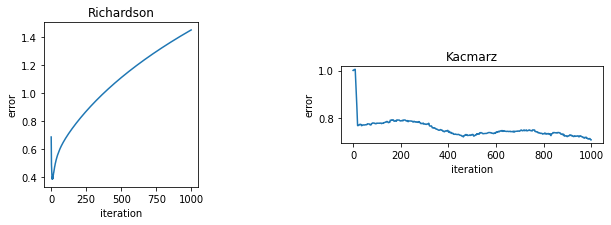

In [22]:
# Plot
fig, ax = plt.subplots(1,2)

ax[0].plot(e_ric)
ax[0].set_xlabel("iteration")
ax[0].set_ylabel("error")
ax[0].set_aspect(niter)
ax[0].set_title("Richardson")

ax[1].plot(e_kaz)
ax[1].set_xlabel("iteration")
ax[1].set_ylabel("error")
ax[1].set_aspect(niter)
ax[1].set_title("Kacmarz")

fig.tight_layout()
fig.set_figwidth(10)
fig.set_figheight(2.5)

fig.savefig("./figures/lec5/reconstruction_errors.png", 
            dpi=300, transparent = True, bbox_inches = "tight", pad_inches = 0)